In [1]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(150, 150, 3))

Using TensorFlow backend.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

58892288/58889256 [==============================] - 11s 0us/step


In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [8]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

baseDir = '/home/chen/LiChiChang/2020SpringThesis/dataset/CatDog/shrink'
trainDir = os.path.join(baseDir, 'train')
validationDir = os.path.join(baseDir, 'validation')
testDir = os.path.join(baseDir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batchSize = 20

def extractFeature(dir, sampleCount):
    features = np.zeros(shape=(sampleCount,4,4,512))
    labels = np.zeros(shape=(sampleCount))
    generator = datagen.flow_from_directory(dir, target_size=(150,150), batch_size=batchSize, class_mode='binary')
    i = 0
    for inputsBatch, labelsBatch in generator:
        featuresBatch = conv_base.predict(inputsBatch)
        features[i * batchSize: (i + 1)*batchSize] = featuresBatch
        labels[i * batchSize: (i + 1)*batchSize] = labelsBatch
        i += 1
        if i*batchSize >= sampleCount:
            break
    return features, labels

trainFeatures, trainLabels = extractFeature(trainDir, 2000)
validationFeatures, validationLabels = extractFeature(validationDir, 1000)
testFeatures, testLabels = extractFeature(testDir, 1000)

trainFeatures = np.reshape(trainFeatures, (2000, 4*4*512))
validationFeatures = np.reshape(validationFeatures, (1000, 4*4*512))
testFeatures = np.reshape(testFeatures, (1000, 4*4*512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
from keras import models, layers, optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

history = model.fit(trainFeatures, trainLabels, epochs=30, batch_size=20, validation_data=(validationFeatures,validationLabels))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 383us/step - loss: 0.6156 - acc: 0.6610 - val_loss: 0.4495 - val_acc: 0.8210
Epoch 2/30
2000/2000 [==============================] - 1s 355us/step - loss: 0.4351 - acc: 0.7940 - val_loss: 0.3636 - val_acc: 0.8610
Epoch 3/30
2000/2000 [==============================] - 1s 354us/step - loss: 0.3508 - acc: 0.8520 - val_loss: 0.3196 - val_acc: 0.8810
Epoch 4/30
2000/2000 [==============================] - 1s 355us/step - loss: 0.3156 - acc: 0.8670 - val_loss: 0.3041 - val_acc: 0.8750
Epoch 5/30
2000/2000 [==============================] - 1s 356us/step - loss: 0.2822 - acc: 0.8910 - val_loss: 0.2849 - val_acc: 0.8870
Epoch 6/30
2000/2000 [==============================] - 1s 357us/step - loss: 0.2621 - acc: 0.8930 - val_loss: 0.2775 - val_acc: 0.8860
Epoch 7/30
2000/2000 [====================

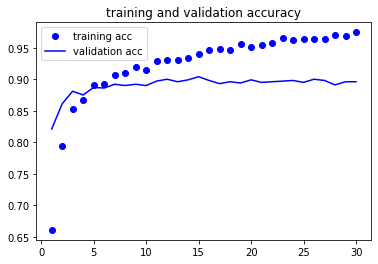

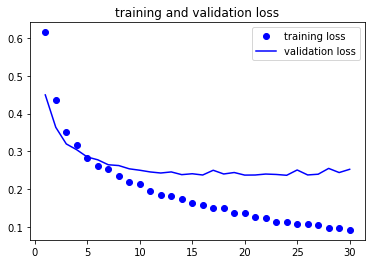

step 5 is complete


In [15]:
import matplotlib.pyplot as plt

acc = history.history['acc']
validationAcc = history.history['val_acc']

loss = history.history['loss']
validationLoss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, validationAcc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, validationLoss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()


In [16]:
'''
Listing 5.20
Combine the 2 models into 1
'''

from keras import models, layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [21]:
model.summary()
print('before freezing the convnet:' , len(model.trainable_weights))
conv_base.trainable = False
print('after freezing the convnet:' , len(model.trainable_weights))


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________
before freezing the convnet: 30
after freezing the convnet: 4


In [23]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

trainDatagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
trainGenerator = trainDatagen.flow_from_directory(trainDir, target_size=(150,150), batch_size=20, class_mode='binary')

validationDatagen = ImageDataGenerator(rescale=1./255)#validation and test dataset shouldn't be augmented
validationGenerator = validationDatagen.flow_from_directory(validationDir, target_size=(150,150), batch_size=20, class_mode='binary')

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

history = model.fit_generator(trainGenerator, steps_per_epoch=100, epochs=30, validation_data=validationGenerator, validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 12s 117ms/step - loss: 0.5945 - acc: 0.6890 - val_loss: 0.2921 - val_acc: 0.8110
Epoch 2/30
100/100 [==============================] - 11s 107ms/step - loss: 0.4778 - acc: 0.7870 - val_loss: 0.3544 - val_acc: 0.8630
Epoch 3/30
100/100 [==============================] - 10s 102ms/step - loss: 0.4240 - acc: 0.8055 - val_loss: 0.2788 - val_acc: 0.8760
Epoch 4/30
100/100 [==============================] - 11s 109ms/step - loss: 0.3992 - acc: 0.8275 - val_loss: 0.2089 - val_acc: 0.8840
Epoch 5/30
100/100 [==============================] - 11s 106ms/step - loss: 0.3768 - acc: 0.8335 - val_loss: 0.3081 - val_acc: 0.8900
Epoch 6/30
100/100 [==============================] - 11s 110ms/step - loss: 0.3770 - acc: 0.8325 - val_loss: 0.3452 - val_acc: 0.8890
Epoch 7/30
100/100 [==============================] - 11s 108ms/step - loss: 0.3648 - acc: 0.8400 - val_lo

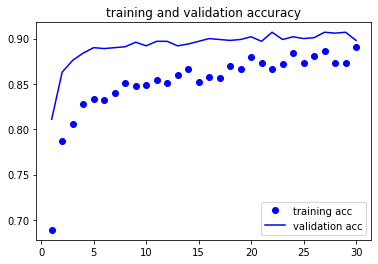

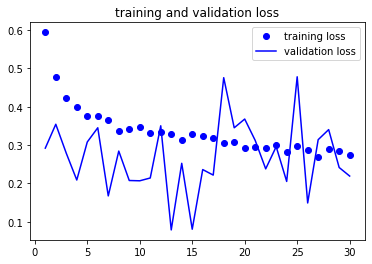

In [24]:
import matplotlib.pyplot as plt

acc = history.history['acc']
validationAcc = history.history['val_acc']

loss = history.history['loss']
validationLoss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, validationAcc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, validationLoss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [25]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable == True
    layer.trainable = set_trainable

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc'])

history = model.fit_generator(trainGenerator, steps_per_epoch=100, epochs=100, validation_data=validationGenerator, validation_steps=50)

Epoch 1/100
100/100 [==============================] - 12s 118ms/step - loss: 0.2692 - acc: 0.8850 - val_loss: 0.2149 - val_acc: 0.9030
Epoch 2/100
100/100 [==============================] - 11s 108ms/step - loss: 0.2565 - acc: 0.8930 - val_loss: 0.1343 - val_acc: 0.9000
Epoch 3/100
100/100 [==============================] - 11s 109ms/step - loss: 0.2734 - acc: 0.8770 - val_loss: 0.2884 - val_acc: 0.9050
Epoch 4/100
100/100 [==============================] - 11s 107ms/step - loss: 0.2738 - acc: 0.8900 - val_loss: 0.2200 - val_acc: 0.8960
Epoch 5/100
100/100 [==============================] - 10s 105ms/step - loss: 0.2727 - acc: 0.8740 - val_loss: 0.1307 - val_acc: 0.9040
Epoch 6/100
100/100 [==============================] - 11s 108ms/step - loss: 0.2820 - acc: 0.8820 - val_loss: 0.2317 - val_acc: 0.9060
Epoch 7/100
100/100 [==============================] - 10s 104ms/step - loss: 0.2770 - acc: 0.8805 - val_loss: 0.1942 - val_acc: 0.9020
Epoch 8/100
100/100 [===========================

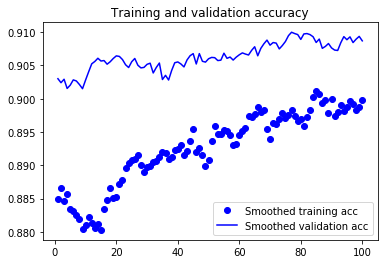

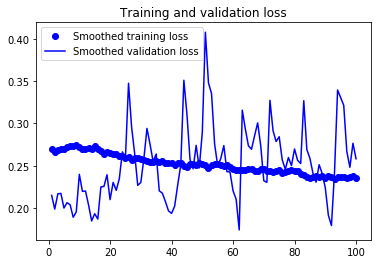

In [33]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
plt.plot(epochs,smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()